In [16]:
import numpy as np
# from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
from pprint import pprint
import scipy.ndimage
from IPython.display import display, Audio
from estimator import ActivationLearner
import scipy.signal
import logging
import beat_track
from unmixdb import UnmixDB
plt.style.use("dark_background")
logging.basicConfig(level=logging.INFO)
logging.getLogger("activation_learner").setLevel(logging.DEBUG)
from pathlib import Path
import scipy.sparse

In [17]:
# Load audios

FS = 22050
input_paths = ["linear-mix-1.wav", "linear-mix-2.wav", "linear-mix.wav"]
# input_paths = ["linear-mix.wav"]
# input_paths = ["original.wav", "original.wav"]
# input_paths = ["original.wav", "boucled.wav"]
# input_paths = ["amen.wav", "high.wav", "nuttah.wav"]
# input_paths = ["nuttah.wav", "nuttah-timestretch.wav"]
inputs = [librosa.load(i, sr=FS)[0] for i in input_paths]


## load unmixdb
# unmixdb = UnmixDB("/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo")
# print(unmixdb.timestretches)
# print(unmixdb.fxes)
# mixes = dict(filter(lambda i: i[1].timestretch == "stretch" and i[1].fx=="none", unmixdb.mixes.items()))
# mix = list(mixes.values())[5]
# pprint(mix)
# inputs = [unmixdb.refsongs[track['name']].audio(sr=FS) for track in mix.tracks]
# inputs.append(mix.audio(sr=FS))

for i, x in enumerate(inputs):
    print(i)
    display(Audio(x, rate=FS))

0


1


2


INFO:estimator:win_len=88200
INFO:estimator:hop_len=22050


loss=1.65e-02 dloss=9.97e-05: : 56it [00:00, 199.31it/s]


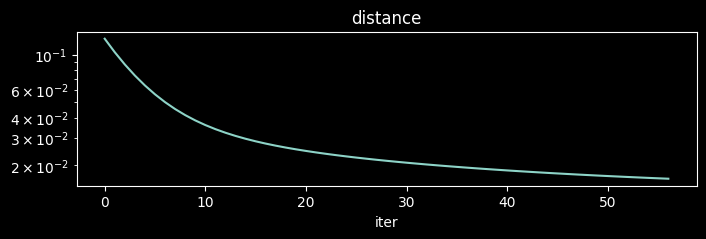

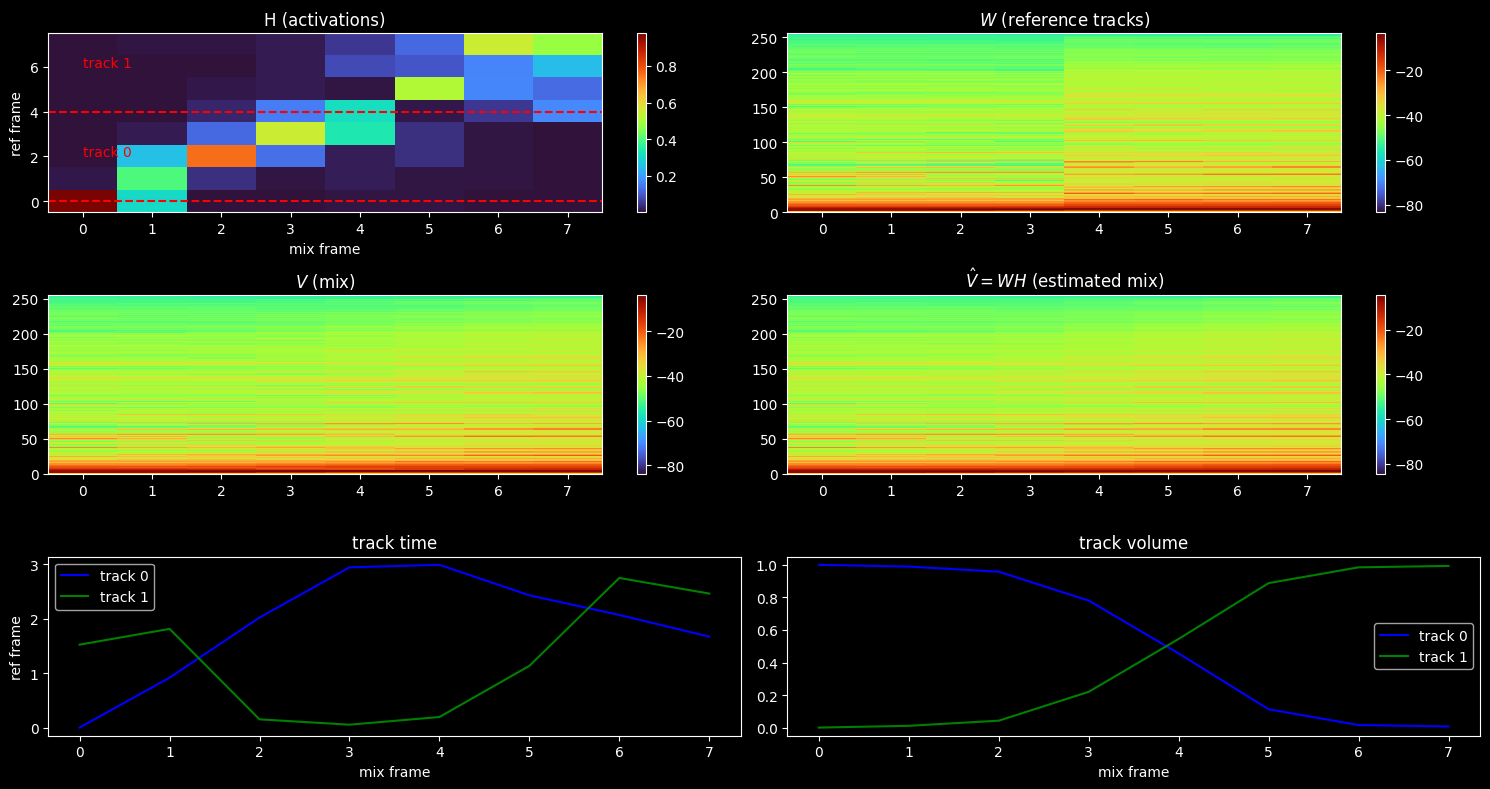

INFO:estimator:win_len=44100
INFO:estimator:hop_len=11025


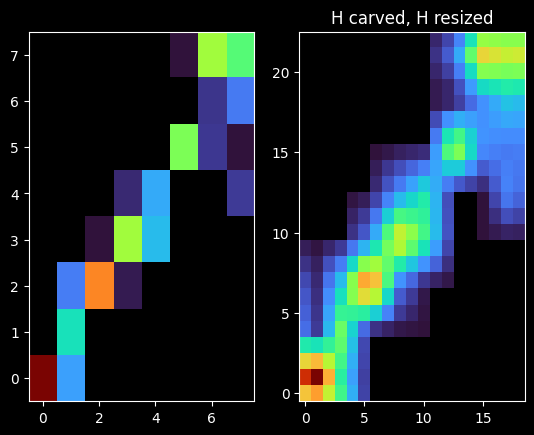

loss=1.86e-02 dloss=9.76e-05: : 59it [00:00, 184.11it/s]


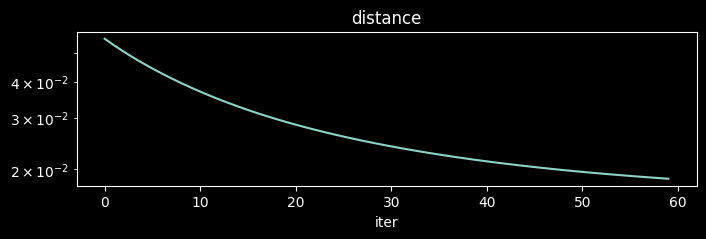

/home/etiandre/stage/.venv/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1542: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


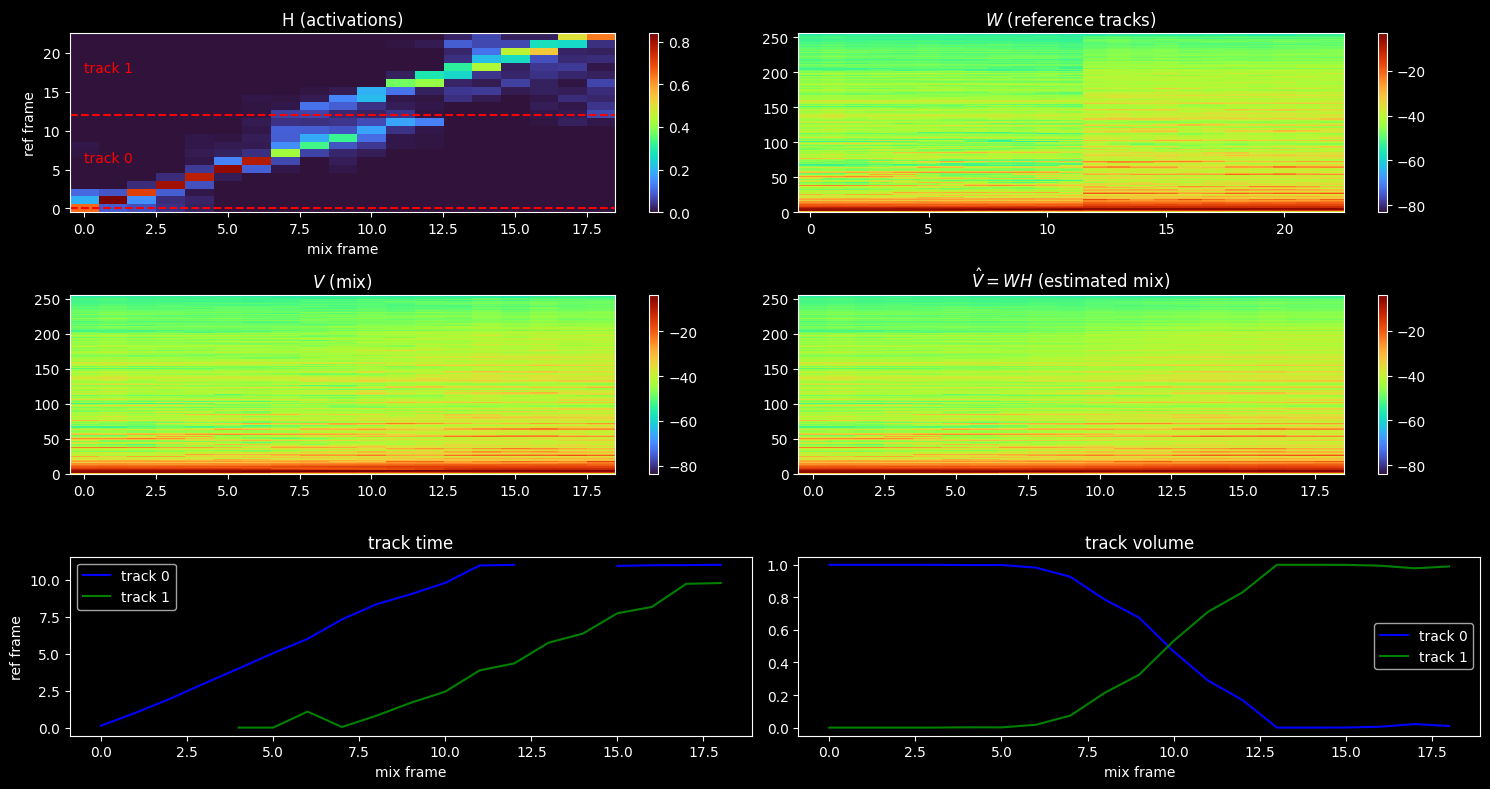

INFO:estimator:win_len=22050
INFO:estimator:hop_len=5512


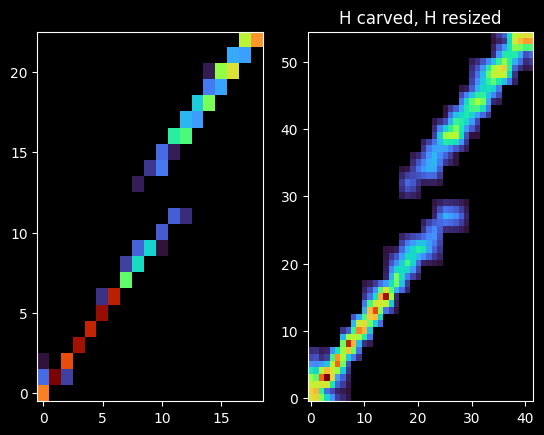

loss=1.99e-02 dloss=9.81e-05: : 49it [00:00, 172.41it/s]


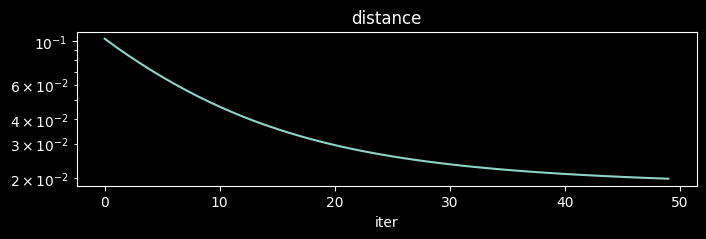

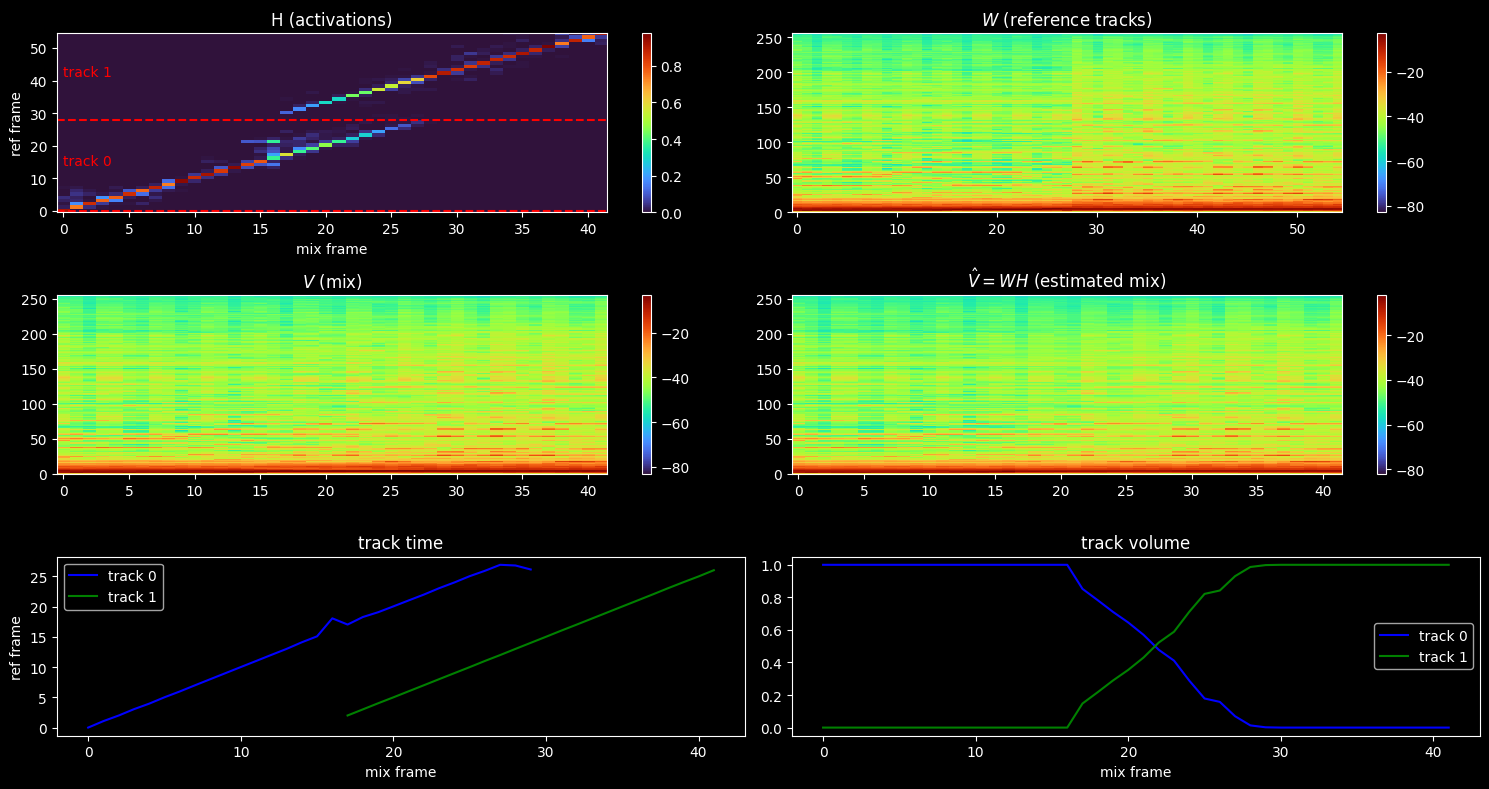

INFO:estimator:win_len=11025
INFO:estimator:hop_len=2756


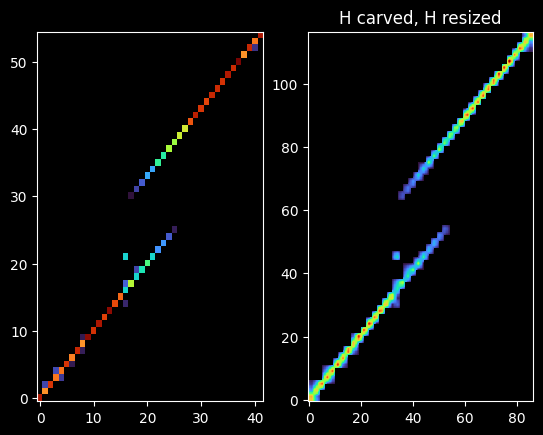

loss=2.36e-02 dloss=9.74e-05: : 41it [00:00, 99.62it/s] 


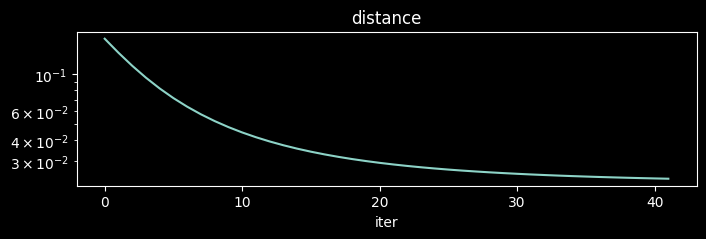

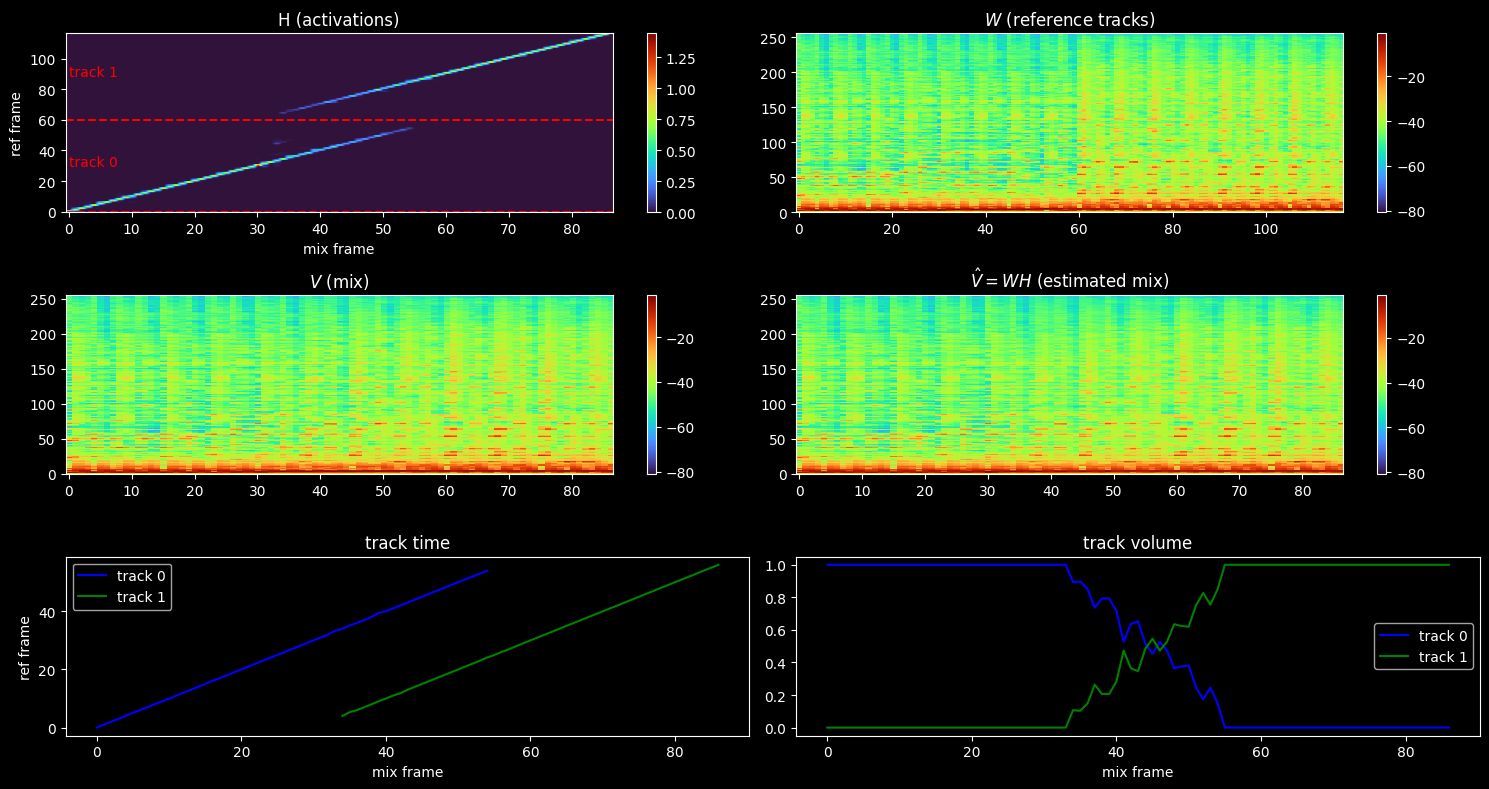

INFO:estimator:win_len=5512
INFO:estimator:hop_len=1378


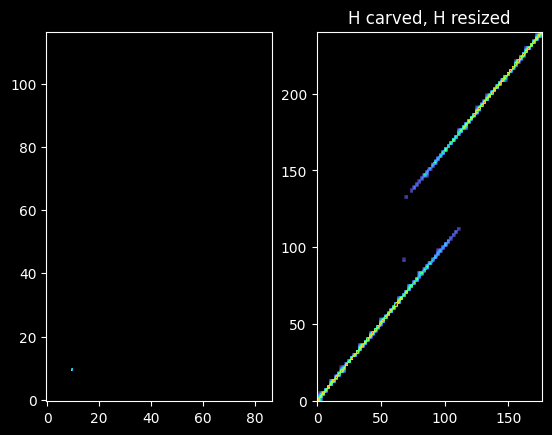

loss=2.71e-02 dloss=9.88e-05: : 40it [00:00, 82.91it/s]


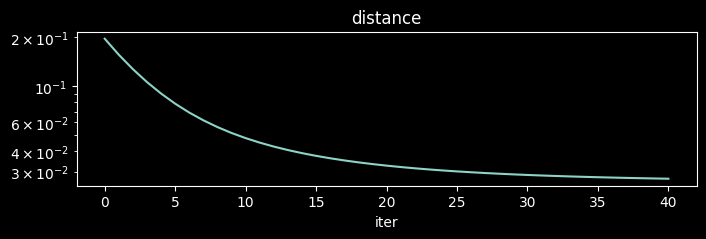

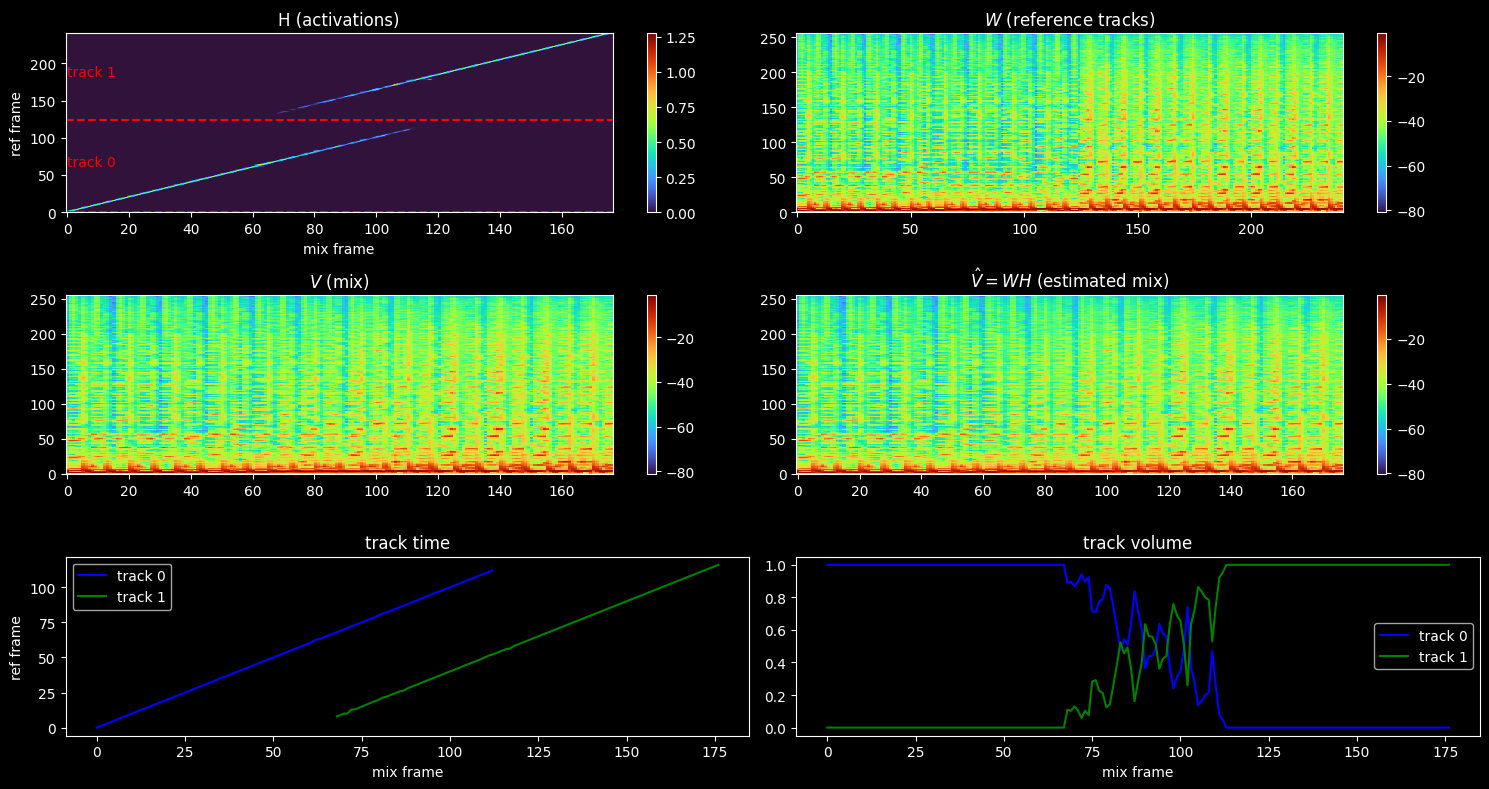

In [23]:
import itertools


def find_largest_nearzero_submatrix(H: np.ndarray, threshold):
    rows, cols = H.shape

    # Create auxiliary matrices to store the size of the largest zero submatrix ending at (i, j)
    aux = np.zeros_like(H, dtype=int)

    max_size = 0
    max_pos = (-1, -1)

    for i in range(rows):
        for j in range(cols):
            if 0 < H[i, j] < threshold:
                if i == 0 or j == 0:
                    # The first row and first column must be handled separately
                    aux[i, j] = 1
                else:
                    # Build on the previous submatrix sizes
                    aux[i, j] = min(aux[i, j - 1], aux[i - 1, j], aux[i - 1, j - 1]) + 1

                if aux[i, j] > max_size:
                    max_size = aux[i, j]
                    max_pos = (i, j)

    if max_size == 0:
        return None  # No zero submatrix found

    # Extract the largest zero submatrix
    top_left = (max_pos[0] - max_size + 1, max_pos[1] - max_size + 1)
    bottom_right = max_pos

    return top_left[0], bottom_right[0] + 1, top_left[1], bottom_right[1] + 1

def carve(H: np.ndarray, threshold):
    while True:
        rect = find_largest_nearzero_submatrix(H, threshold)
        if rect is None:
            break
        top, bottom, left, right = rect
        width, height = bottom - top, right - left
        area = (bottom-top) * (right-left)
        H[top:bottom, left:right] = 0
    return H

def carve_naive(H: np.ndarray, threshold):
    H[H<threshold] = 0
    return H

def imshow_highlight_zero(X: np.ndarray, **kwargs):
    X_ = X.copy()
    X_[X_ == 0] = np.nan
    plt.imshow(X_, **kwargs)
    

WIN_SIZES = [4, 2, 1, 0.5, 0.25]

previous_H = None
for win_size in WIN_SIZES:
    model = ActivationLearner(
        inputs,
        fs=FS,
        n_mels = 256,
        win_size = win_size,
        overlap = 0.75,
        stft_win_func=np.hanning,
    )
    
    if previous_H is not None:
        import skimage.transform
        previous_H = carve_naive(previous_H.toarray(), 0.1)
        plt.subplot(1,2,1)
        imshow_highlight_zero(previous_H, cmap="turbo", origin="lower", aspect="auto")
        previous_H = skimage.transform.resize(previous_H, model.nmf.H.shape, order=1, preserve_range=True)
        plt.subplot(1,2,2)
        imshow_highlight_zero(previous_H, cmap="turbo", origin="lower", aspect="auto")
        plt.title("H carved, H resized")
        plt.show()
        previous_H[previous_H == np.nan] = 0
        previous_H = scipy.sparse.bsr_array(previous_H)
        model.nmf.H = previous_H

    losses = []
    for i in (pbar := tqdm(itertools.count())):
        loss = model.iterate()
        if i == 0:
            dloss = np.inf
        else:
            dloss = abs(losses[-1] - loss)
        losses.append(loss)
        pbar.set_description(f"{loss=:.2e} {dloss=:.2e}")
        if dloss < 1e-4: break
    plt.figure(figsize=(8, 2))
    plt.plot(losses)
    plt.xlabel("iter")
    plt.title("distance")
    plt.yscale("log")
    plt.show()
    model.plot()
    
    previous_H = model.nmf.H.copy()